# Atlas 14 Design Storm Generation with LLM Forward Caching

This notebook demonstrates the **LLM Forward caching pattern** for working with NOAA Atlas 14 precipitation data. This approach:

- **Verifiable**: Raw NOAA data saved to known location for review
- **Reproducible**: Same data used across all analyses
- **Fast**: No repeated API calls after initial download
- **Offline**: Works without internet after initial download
- **Audit trail**: Complete primary data source preserved

## LLM Forward Pattern Overview

Instead of downloading Atlas 14 data to memory and discarding it, ras-commander saves the raw NOAA API response to your project folder:

```
project_folder/
└── NOAA_Atlas_14/
    ├── lat38.9_lon-77.0_depth_english_pds.json
    └── ... (other cache files)
```

This cached data becomes the **single source of truth** for all design storms.

In [1]:
# Import ras-commander
from pathlib import Path
import sys

try:
    from ras_commander import *
    print("ras-commander installed")
except ImportError:
    current_file = Path.cwd()
    parent_directory = current_file.parent
    sys.path.insert(0, str(parent_directory))
    from ras_commander import *
    print("ras-commander dev")

from ras_commander.precip import StormGenerator
from ras_commander.hdf import HdfProject
import pandas as pd
import matplotlib.pyplot as plt

ras-commander dev


## Step 1: Extract Example Project and Get Location

We'll use an example HEC-RAS project and determine its location from the model geometry.
The project centroid will be used for the Atlas 14 precipitation query.

In [2]:
# Extract an example project with 2D geometry
project_path = RasExamples.extract_project("BaldEagleCrkMulti2D")
print(f"Extracted project to: {project_path}")

# Initialize the project
init_ras_project(project_path, "6.6")
print(f"Initialized project: {ras.project_name}")
print(f"\nPlans available: {list(ras.plan_df['plan_number'])}")
print(f"Geometries available: {list(ras.geom_df['geom_number'])}")

2025-12-13 20:25:09 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-12-13 20:25:09 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-13 20:25:09 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-13 20:25:09 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-13 20:25:09 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D'
2025-12-13 20:25:09 - ras_commander.RasExamples - INFO - Project 'BaldEagleCrkMulti2D' already exists. Deleting existing folder...
2025-12-13 20:25:10 - ras_commander.RasExamples - INFO - Existing folder for project 'BaldEagleCrkMulti2D' has been deleted.
2025-12-13 20:25:11 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D
2025-12-13 20:25:11 - ras_commander.RasMap - INFO - Successfully

Extracted project to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D
Initialized project: BaldEagleDamBrk

Plans available: ['13', '15', '17', '18', '19', '03', '04', '02', '01', '05', '06']
Geometries available: ['06', '08', '10', '11', '12', '09', '13', '01', '03', '02']


In [3]:
# Get the geometry HDF file path
# Find a geometry with an HDF file
geom_hdf_path = None
for _, row in ras.geom_df.iterrows():
    geom_path = row.get('full_path')
    if geom_path:
        hdf_candidate = Path(str(geom_path) + '.hdf')
        if hdf_candidate.exists():
            geom_hdf_path = hdf_candidate
            print(f"Found geometry HDF: {geom_hdf_path}")
            break

if geom_hdf_path is None:
    # Try plan HDF files which also contain geometry
    for _, row in ras.plan_df.iterrows():
        hdf_path = row.get('HDF_Results_Path')
        if hdf_path and Path(hdf_path).exists():
            geom_hdf_path = Path(hdf_path)
            print(f"Using plan HDF for geometry: {geom_hdf_path}")
            break

if geom_hdf_path is None:
    raise FileNotFoundError("No HDF file found with geometry data")

print(f"\nUsing HDF file: {geom_hdf_path.name}")

Found geometry HDF: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g06.hdf

Using HDF file: BaldEagleDamBrk.g06.hdf


In [4]:
# Get project bounds in lat/lon coordinates
# This automatically extracts geometry from 2D areas, cross sections, etc.
west, south, east, north = HdfProject.get_project_bounds_latlon(
    geom_hdf_path,
    buffer_percent=0.0  # No buffer - we just want the actual project extent
)

# Calculate centroid
lat = (north + south) / 2
lon = (east + west) / 2

print(f"Project Bounds (WGS84):")
print(f"  West:  {west:.6f}")
print(f"  East:  {east:.6f}")
print(f"  South: {south:.6f}")
print(f"  North: {north:.6f}")
print(f"\nProject Centroid:")
print(f"  Latitude:  {lat:.6f}")
print(f"  Longitude: {lon:.6f}")

2025-12-13 20:25:11 - ras_commander.hdf.HdfProject - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g06.hdf
2025-12-13 20:25:11 - ras_commander.hdf.HdfProject - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g06.hdf
2025-12-13 20:25:11 - ras_commander.hdf.HdfProject - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g06.hdf
2025-12-13 20:25:11 - ras_commander.hdf.HdfProject - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g06.hdf
2025-12-13 20:25:11 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g06.hdf
2025-12-13 20:25:11 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\G

Project Bounds (WGS84):
  West:  -77.758870
  East:  -77.391037
  South: 40.960741
  North: 41.145314

Project Centroid:
  Latitude:  41.053028
  Longitude: -77.574953


## Step 2: Download and Cache Atlas 14 Data

**First time**: Downloads from NOAA API and saves to cache

**Subsequent times**: Loads from cache (no API request)

In [5]:
print(f"Project folder: {project_path}")
print(f"Coordinates: ({lat:.4f}, {lon:.4f})")
print("\n" + "="*70)
print("DOWNLOADING ATLAS 14 DATA (or loading from cache)")
print("="*70)

# Download and cache Atlas 14 data using project centroid
gen = StormGenerator.download_from_coordinates(
    lat=lat,
    lon=lon,
    project_folder=project_path  # CRITICAL: This enables caching to the project folder
)

# Check cache location
cache_dir = project_path / "NOAA_Atlas_14"
cache_file = cache_dir / f"lat{lat}_lon{lon}_depth_english_pds.json"

if cache_file.exists():
    print(f"\n✓ Cache file exists: {cache_file}")
    print(f"  File size: {cache_file.stat().st_size / 1024:.1f} KB")
else:
    # Check for any cache file (coordinates might be slightly different)
    cache_files = list(cache_dir.glob("*.json")) if cache_dir.exists() else []
    if cache_files:
        print(f"\n✓ Cache file found: {cache_files[0].name}")
        print(f"  File size: {cache_files[0].stat().st_size / 1024:.1f} KB")
    else:
        print(f"\n⚠ Cache file not found in: {cache_dir}")

2025-12-13 20:25:11 - ras_commander.precip.StormGenerator - INFO - Downloading Atlas 14 data for (41.05302775109011, -77.57495349718292)...


Project folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D
Coordinates: (41.0530, -77.5750)

DOWNLOADING ATLAS 14 DATA (or loading from cache)


2025-12-13 20:25:12 - ras_commander.precip.StormGenerator - INFO - Cached Atlas 14 data to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\NOAA_Atlas_14\lat41.05302775109011_lon-77.57495349718292_depth_english_pds.json
2025-12-13 20:25:12 - ras_commander.precip.StormGenerator - INFO - Downloaded Atlas 14 data for region: Ohio River Basin



✓ Cache file exists: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\NOAA_Atlas_14\lat41.05302775109011_lon-77.57495349718292_depth_english_pds.json
  File size: 9.6 KB


## Step 3: Generate Design Storms from Cached Data

All subsequent storm generations use the cached data - **no additional API calls**.

In [6]:
# Define AEP events (return periods)
aep_events = [2, 5, 10, 25, 50, 100]  # years
duration_hours = 24
position_percent = 50  # Centered peak

print("Generating design storms for AEP events:")
print(f"  Events: {aep_events}")
print(f"  Duration: {duration_hours} hours")
print(f"  Peak position: {position_percent}%")
print()

# Generate hyetographs
hyetographs = {}

for ari in aep_events:
    print(f"Generating {ari}-year event...")
    
    # Generate from cached data
    hyeto = gen.generate_hyetograph(
        ari=ari,
        duration_hours=duration_hours,
        position_percent=position_percent
    )
    
    hyetographs[ari] = hyeto
    
    # Show total depth
    total_depth = hyeto['cumulative_depth'].iloc[-1]
    print(f"  {ari}-year, {duration_hours}-hr total depth: {total_depth:.2f} inches")

print("\n✓ All hyetographs generated from cached data")

2025-12-13 20:25:12 - ras_commander.precip.StormGenerator - INFO - Generated 2-year, 24-hour hyetograph (peak at 50%, total depth: 2.680)
2025-12-13 20:25:12 - ras_commander.precip.StormGenerator - INFO - Generated 5-year, 24-hour hyetograph (peak at 50%, total depth: 3.310)
2025-12-13 20:25:12 - ras_commander.precip.StormGenerator - INFO - Generated 10-year, 24-hour hyetograph (peak at 50%, total depth: 3.830)
2025-12-13 20:25:12 - ras_commander.precip.StormGenerator - INFO - Generated 25-year, 24-hour hyetograph (peak at 50%, total depth: 4.580)
2025-12-13 20:25:12 - ras_commander.precip.StormGenerator - INFO - Generated 50-year, 24-hour hyetograph (peak at 50%, total depth: 5.210)
2025-12-13 20:25:12 - ras_commander.precip.StormGenerator - INFO - Generated 100-year, 24-hour hyetograph (peak at 50%, total depth: 5.890)


Generating design storms for AEP events:
  Events: [2, 5, 10, 25, 50, 100]
  Duration: 24 hours
  Peak position: 50%

Generating 2-year event...
  2-year, 24-hr total depth: 2.68 inches
Generating 5-year event...
  5-year, 24-hr total depth: 3.31 inches
Generating 10-year event...
  10-year, 24-hr total depth: 3.83 inches
Generating 25-year event...
  25-year, 24-hr total depth: 4.58 inches
Generating 50-year event...
  50-year, 24-hr total depth: 5.21 inches
Generating 100-year event...
  100-year, 24-hr total depth: 5.89 inches

✓ All hyetographs generated from cached data


## Step 4: Visualize Design Storms

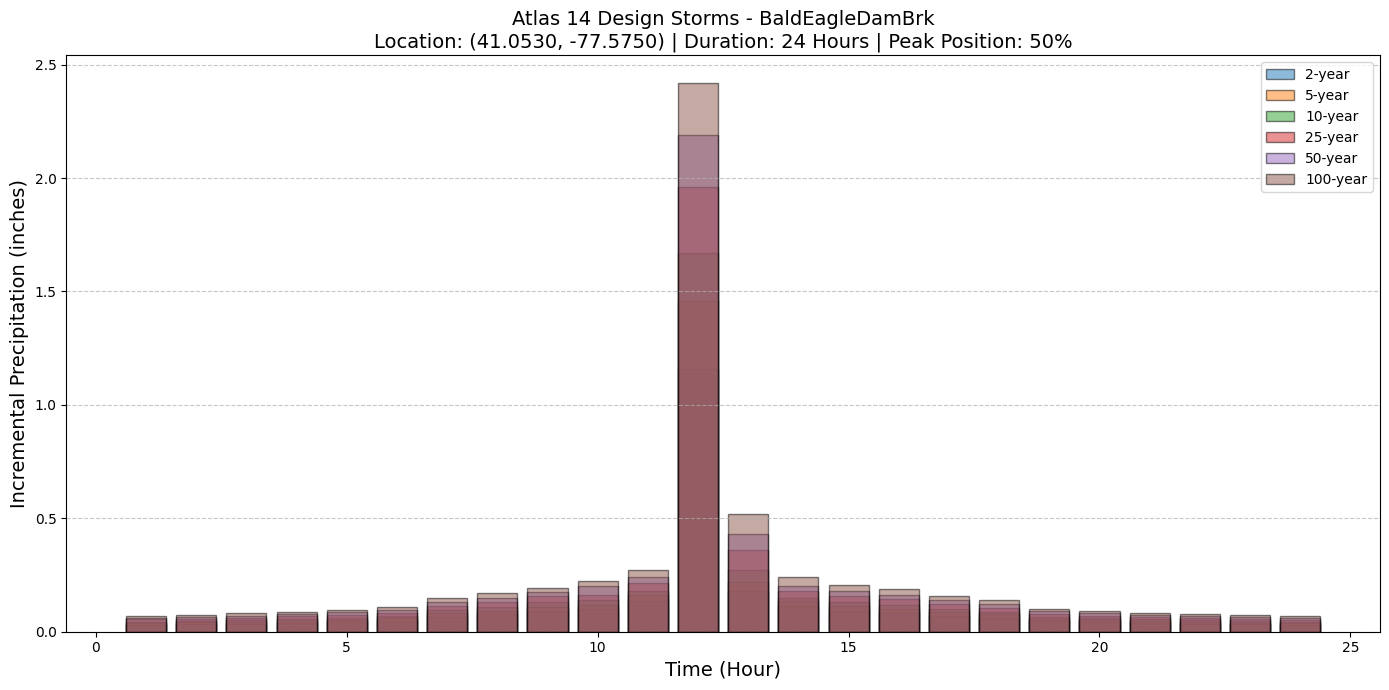

In [7]:
# Plot comparison
plt.figure(figsize=(14, 7))

for ari in aep_events:
    hyeto = hyetographs[ari]
    plt.bar(
        hyeto['hour'], 
        hyeto['incremental_depth'],
        width=0.8,
        alpha=0.5,
        edgecolor='black',
        label=f'{ari}-year'
    )

plt.xlabel('Time (Hour)', fontsize=14)
plt.ylabel('Incremental Precipitation (inches)', fontsize=14)
plt.title(f'Atlas 14 Design Storms - {ras.project_name}\n'
          f'Location: ({lat:.4f}, {lon:.4f}) | Duration: {duration_hours} Hours | Peak Position: {position_percent}%', 
          fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Step 5: Export for HEC-RAS

Hyetographs can be exported to CSV for incorporation into HEC-RAS unsteady flow files.

In [8]:
# Create output directory within project folder
output_dir = project_path / "hyetographs"
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving hyetographs to: {output_dir}")
print()

# Save each hyetograph
for ari in aep_events:
    hyeto = hyetographs[ari]
    
    # Create filename
    filename = f"hyetograph_ARI_{ari}_years_pos{position_percent}pct_{duration_hours}hr.csv"
    filepath = output_dir / filename
    
    # Save to CSV
    hyeto.to_csv(filepath, index=False)
    print(f"✓ Saved: {filename}")

print(f"\nAll hyetographs saved to: {output_dir}")

Saving hyetographs to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\hyetographs

✓ Saved: hyetograph_ARI_2_years_pos50pct_24hr.csv
✓ Saved: hyetograph_ARI_5_years_pos50pct_24hr.csv
✓ Saved: hyetograph_ARI_10_years_pos50pct_24hr.csv
✓ Saved: hyetograph_ARI_25_years_pos50pct_24hr.csv
✓ Saved: hyetograph_ARI_50_years_pos50pct_24hr.csv
✓ Saved: hyetograph_ARI_100_years_pos50pct_24hr.csv

All hyetographs saved to: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\hyetographs


## Step 6: Verify Cached Data

The cached Atlas 14 data is human-readable JSON. Let's inspect it to verify the primary data source.

In [9]:
import json

# Find the cache file
cache_dir = project_path / "NOAA_Atlas_14"
cache_files = list(cache_dir.glob("*.json")) if cache_dir.exists() else []

if cache_files:
    cache_file = cache_files[0]
    
    # Read cached data
    with open(cache_file, "r") as f:
        cached_data = json.load(f)
    
    print("Atlas 14 Cached Data Structure:")
    print("="*70)
    print(f"Region: {cached_data.get('region', 'Unknown')}")
    print(f"Latitude: {cached_data.get('lat')}")
    print(f"Longitude: {cached_data.get('lon')}")
    print(f"Units: {cached_data.get('unit', 'Unknown')}")
    print(f"Series Type: {cached_data.get('ser', 'Unknown')}")
    print()
    
    quantiles = cached_data.get("quantiles", [])
    print(f"Number of durations: {len(quantiles)}")
    print(f"Number of return periods per duration: {len(quantiles[0]) if quantiles else 0}")
    print()
    print("Sample data (first duration, all return periods):")
    print(f"  {quantiles[0] if quantiles else []}")
    print()
    print("Raw NOAA data preserved in project folder")
    print(f"  Location: {cache_file}")
    print(f"  This file is the authoritative source for all design storms")
else:
    print("No cache file found - data may have been loaded from existing cache")

Atlas 14 Cached Data Structure:
Region: Ohio River Basin
Latitude: 41.0530
Longitude: -77.5750
Units: english
Series Type: pds

Number of durations: 19
Number of return periods per duration: 10

Sample data (first duration, all return periods):
  ['0.312', '0.371', '0.444', '0.499', '0.568', '0.619', '0.670', '0.720', '0.787', '0.835']

Raw NOAA data preserved in project folder
  Location: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\NOAA_Atlas_14\lat41.05302775109011_lon-77.57495349718292_depth_english_pds.json
  This file is the authoritative source for all design storms


## Benefits of LLM Forward Caching

### Traditional Approach (Without Caching)
```python
# Downloads from API every time (slow, requires internet)
gen = StormGenerator.download_from_coordinates(lat, lon)
# Data discarded after use - no audit trail
```

### LLM Forward Approach (With Caching)
```python
# Get project location from geometry
west, south, east, north = HdfProject.get_project_bounds_latlon(geom_hdf_path)
lat, lon = (north + south) / 2, (east + west) / 2

# First time: Downloads from API and caches
# Subsequent times: Loads from cache (fast, offline)
gen = StormGenerator.download_from_coordinates(
    lat, lon,
    project_folder=project_path  # Enables caching
)
# Raw NOAA data preserved in {project_folder}/NOAA_Atlas_14/
```

### Key Advantages

1. **Verifiable**: Raw NOAA data reviewable by engineers, reviewers, and stakeholders
2. **Reproducible**: Same exact data used every time (no API variability)
3. **Fast**: Subsequent runs load from disk (~ms) instead of API (~seconds)
4. **Offline**: Works without internet after initial download
5. **Audit Trail**: Complete primary data source preserved with project
6. **Location-Aware**: Automatically uses project centroid for queries

### Cache File Format

Cache filename: `lat{lat}_lon{lon}_{data}_{units}_{series}.json`

Example: `lat40.912_lon-77.793_depth_english_pds.json`

Contents: Complete NOAA Atlas 14 API response (human-readable JSON)

## Integration with HEC-RAS Workflows

The generated hyetographs can be integrated into HEC-RAS unsteady flow files:

1. Load hyetograph from CSV
2. Update Precipitation Hydrograph table in `.u##` file
3. Set time interval to match hyetograph
4. Run HEC-RAS simulation

See notebook `103_Running_AEP_Events_from_Atlas_14.ipynb` for complete integration example.